In [449]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import *
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [450]:
Data = pd.read_csv("Car_Crash_Cleaned_AADT.csv")

In [451]:
def PredictionReport(X_values: pd.DataFrame, Y_values: pd.DataFrame, classifier: str = "Gaussian") -> None:
    Observation = X_values.to_numpy()
    Results = Y_values.to_numpy().ravel()
    X_train, X_test, y_train, y_test = train_test_split(Observation, Results, test_size=0.2, random_state=0)
    
    gnb = GaussianNB()
    if classifier == "Multinomial":
        gnb = MultinomialNB()
    elif classifier == "Complement":
        gnb = ComplementNB()
    elif classifier == "Categorical":
        gnb = CategoricalNB()
        
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    print("Number of mislabeled points out of a total %d points : %d"
          % (X_test.shape[0], (y_test != y_pred).sum()))
    print(1 - float((y_test != y_pred).sum())/X_test.shape[0])
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred)
    
    # Print classification report
    print("\nClassification Report:")
    print(class_report)
    values_index = Y_values['Injury Severity'].unique().tolist()
    values_index.sort()
    cm_df = pd.DataFrame(conf_matrix,
                     index = values_index, 
                     columns = values_index)
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

    unique_values, counts = np.unique(y_pred, return_counts=True)
    print("Predicted values:")
    for value, count in zip(unique_values, counts):
        print(f"{value} occurs {count} times")
    unique_values, counts = np.unique(y_test, return_counts=True)
    
    print("\nActual values:")
    for value, count in zip(unique_values, counts):
        print(f"{value} occurs {count} times")

    return None

In [452]:
Known_Injury_Data = Data[(Data["Injury Severity"] != "Unknown Injury Collision")]

In [453]:
X = Known_Injury_Data[['Associated State Road Number','Mile Post','Intersection Related', 'Weather Condition',
       'Lighting Condition',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT']]


In [454]:
values = {"Lighting Condition": 'Unkown', "Weather Condition": 'Other', 'Passengers Involved':0.0, 'Commercial Carrier Involved':0.0,
       'School Bus Involved':0.0, 'Pedestrians Involved':0.0, 'Pedalcyclists Involved':0.0}
X=X.fillna(value=values)
X=X.dropna()

In [455]:
Conditions = ['Weather Condition','Lighting Condition']
Weather_Correspondance = [2,1,0,3,4,8,6,5,7]
Lighting_Correspondance=[3,5,1,7,4,0,6,2,7]

In [456]:
for Condition in Conditions:
    use_list = []
    states = []
    if Condition == 'Weather Condition':
        use_list = Weather_Correspondance = [2,1,0,3,4,8,6,5,7]
        states = X['Weather Condition'].unique()
    else:
        use_list = Lighting_Correspondance=[3,5,2,7,4,0,6,2,7]
        states = X['Lighting Condition'].unique()
    for i in np.arange(X[Condition].unique().shape[0]):
        X.loc[X[Condition] == states[i], Condition] = use_list[i]

In [457]:
Y = Data[['Injury Severity']].iloc[X.index.to_list()]


Number of mislabeled points out of a total 7722 points : 3943
0.4893809893809894
Confusion Matrix:
[[   3   37   18   13]
 [   1  720  783  161]
 [   1 2250 3031  537]
 [   1   82   59   25]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.50      0.04      0.08        71
  Minor Injury Collision       0.23      0.43      0.30      1665
     No Injury Collision       0.78      0.52      0.62      5819
Serious Injury Collision       0.03      0.15      0.06       167

                accuracy                           0.49      7722
               macro avg       0.39      0.29      0.27      7722
            weighted avg       0.64      0.49      0.54      7722



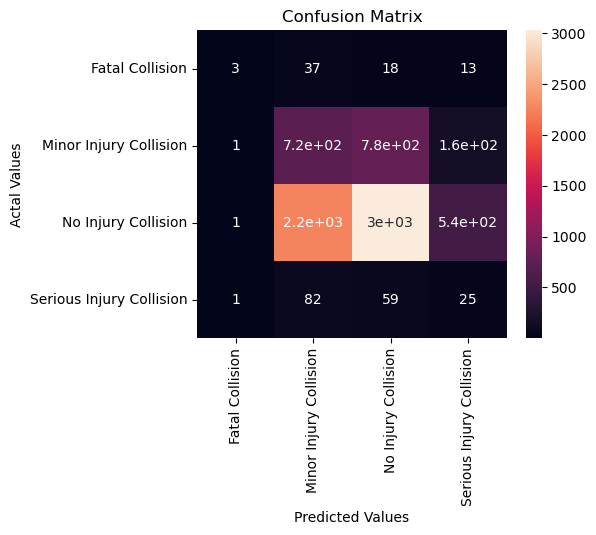

Predicted values:
Fatal Collision occurs 6 times
Minor Injury Collision occurs 3089 times
No Injury Collision occurs 3891 times
Serious Injury Collision occurs 736 times

Actual values:
Fatal Collision occurs 71 times
Minor Injury Collision occurs 1665 times
No Injury Collision occurs 5819 times
Serious Injury Collision occurs 167 times


In [458]:
PredictionReport(X,Y,"Complement")

Number of mislabeled points out of a total 7722 points : 3555
0.5396270396270396
Confusion Matrix:
[[   2   31   38    0]
 [   3  794  863    5]
 [   4 2419 3369   27]
 [   4   67   94    2]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.15      0.03      0.05        71
  Minor Injury Collision       0.24      0.48      0.32      1665
     No Injury Collision       0.77      0.58      0.66      5819
Serious Injury Collision       0.06      0.01      0.02       167

                accuracy                           0.54      7722
               macro avg       0.31      0.27      0.26      7722
            weighted avg       0.64      0.54      0.57      7722



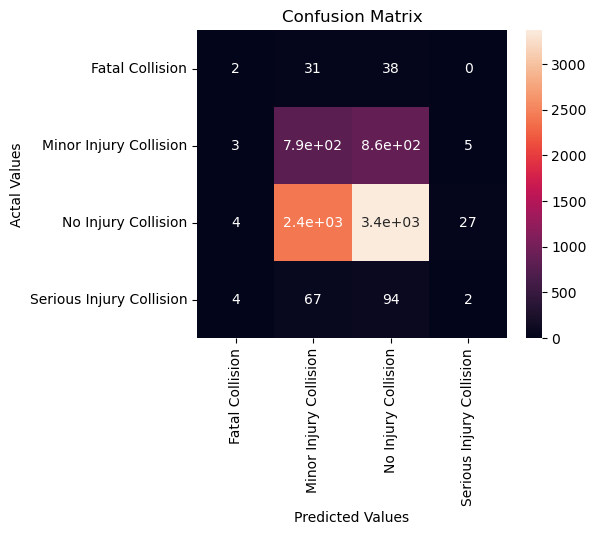

Predicted values:
Fatal Collision occurs 13 times
Minor Injury Collision occurs 3311 times
No Injury Collision occurs 4364 times
Serious Injury Collision occurs 34 times

Actual values:
Fatal Collision occurs 71 times
Minor Injury Collision occurs 1665 times
No Injury Collision occurs 5819 times
Serious Injury Collision occurs 167 times


In [459]:
PredictionReport(X.drop(['AADT'],axis = 1),Y,"Complement")

In [460]:
Y['Injury Severity'] = np.where((Y['Injury Severity'] == "No Injury Collision") 
| (Y["Injury Severity"] == "Minor Injury Collision"), "Non-Severe Injury", "Severe Injury")


Number of mislabeled points out of a total 7722 points : 3573
0.5372960372960374
Confusion Matrix:
[[3991 3493]
 [  80  158]]

Classification Report:
                   precision    recall  f1-score   support

Non-Severe Injury       0.98      0.53      0.69      7484
    Severe Injury       0.04      0.66      0.08       238

         accuracy                           0.54      7722
        macro avg       0.51      0.60      0.39      7722
     weighted avg       0.95      0.54      0.67      7722



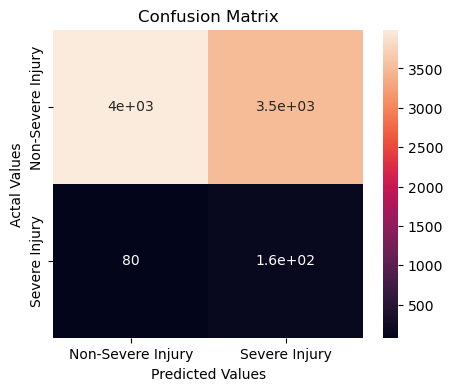

Predicted values:
Non-Severe Injury occurs 4071 times
Severe Injury occurs 3651 times

Actual values:
Non-Severe Injury occurs 7484 times
Severe Injury occurs 238 times


In [461]:
PredictionReport(X,Y,"Complement")

In [462]:
RData = Known_Injury_Data[Known_Injury_Data['County'].notna() & Known_Injury_Data['Weather Condition'].notna() & Known_Injury_Data['Lighting Condition'].notna()]
RData = RData.join(pd.get_dummies(RData[['County','Weather Condition','Lighting Condition']], dtype=float))
RData = RData[RData["Injury Severity"] != "Unknown Injury Collision"]

In [463]:
RData = RData.drop(['County','Weather Condition','Lighting Condition',
        'Collision Report Number', 'Collision Date', 'City', 'Jurisdiction',
       'Agency', 'Primary Trafficway', 'Primary Road Number',
       'Secondary Trafficway', 'Secondary Road Number', 'Block Number',
                   'Object Struck', 'Damage Threshold Met', 'Hit and Run', 'Mile Post'], axis=1)

In [464]:
#Distincting level of injury
RegressData = RData.replace({'Injury Severity': {"No Injury Collision": 0, 
                                   'Minor Injury Collision': 1,
                                  "Serious Injury Collision": 2, 
                                   'Fatal Collision': 3}})

In [465]:
RX = RegressData[['Injury Severity','Associated State Road Number',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]

In [466]:
RX = RX.dropna()

In [467]:
RY = RX['Injury Severity']
RX = RX[['Associated State Road Number',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]

In [468]:
X_model = sm.add_constant(RX)
model = sm.OLS(RY, X_model)
results = model.fit()

In [469]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Injury Severity   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     58.36
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        23:19:44   Log-Likelihood:                -32946.
No. Observations:               42360   AIC:                         6.602e+04
Df Residuals:                   42295   BIC:                         6.658e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [470]:
#Just finding between severe Injury or not
RegressData = RData.replace({'Injury Severity': {"No Injury Collision": 0, 
                                   'Minor Injury Collision': 0,
                                  "Serious Injury Collision": 1, 
                                   'Fatal Collision': 1}})
RX = RegressData[['Injury Severity','Associated State Road Number', 
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]
RX = RX.dropna()
RY = RX['Injury Severity']
RX = RX[['Associated State Road Number',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]
X_model = sm.add_constant(RX)
model = sm.OLS(RY, X_model)
results = model.fit()

In [471]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Injury Severity   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     56.82
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        23:19:45   Log-Likelihood:                 16762.
No. Observations:               42360   AIC:                        -3.339e+04
Df Residuals:                   42295   BIC:                        -3.283e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [472]:
Known_Injury_Data['AADT'].to_numpy()*(-5.155 *10**(-7)) +  0.5556

array([0.512298 , 0.51436  , 0.5528163, ..., 0.463841 , 0.5385885,
       0.5385885])

In [473]:
Known_Injury_Data['AADT'].to_numpy()

array([ 84000.,  80000.,   5400., ..., 178000.,  33000.,  33000.])

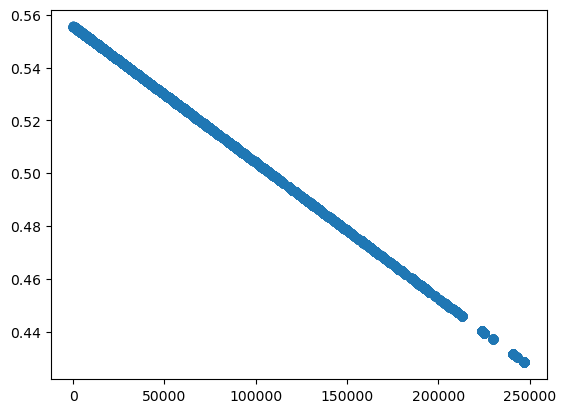

In [477]:
plt.scatter(Known_Injury_Data['AADT'].to_numpy(), Known_Injury_Data['AADT'].to_numpy()*(-5.155 *10**(-7)) +  0.5556)

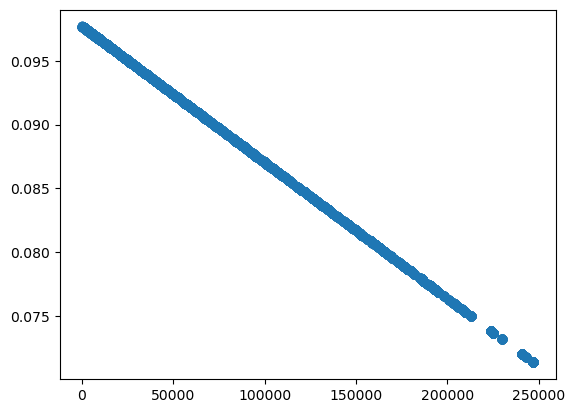

In [478]:
plt.scatter(Known_Injury_Data['AADT'].to_numpy(), Known_Injury_Data['AADT'].to_numpy()*(-1.067 * 10**(-7)) +  0.0977)